<div align=center style="direction:rtl">
    <font face="XB Niloofar", size=5>
        به نام خدا
        <br/>
        <br/>
        دانشگاه صنعتی شریف- دانشکده برق
        <br />
        <br/>
        استنتاج علّی
        <br />
        <br />
        تمرین کامپیوتری دوم
        <br/>
        <br/>
        دکتر صالح
        <br />
        <br/>
        سجاد رحمانیان
    </font>
</div>

<font color="orange" size="5">
Importing necessary libraries:
</font>

In [6]:
import numpy as np
from itertools import chain, combinations
from scipy.stats import pearsonr, norm
from sklearn.linear_model import LinearRegression
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from math import nan, isnan
import time
from tqdm import tqdm
from random import choice, choices, sample
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

<font color="orange" size="4">
A function for drawing graphs:
</font>

In [7]:
def show_graph_with_labels(adjacency_matrix, mylabels=None):
    if mylabels is None:
        mylabels = np.arange(adjacency_matrix.shape[0])
    rows, cols = np.where(adjacency_matrix == 1)
    edges = zip(rows.tolist(), cols.tolist())
    gr = nx.Graph()
    m = {i:mylabels[i] for i in range(len(mylabels))}
    gr.add_nodes_from(m)
    gr.add_edges_from(edges)
    nx.draw(gr, node_size=500, labels=m, with_labels=True)
    plt.show()

<font color="orange" size=4>
    Implementing indepTest. To read more about partial correlation read
    <font color="blue">
        <a href="https://en.wikipedia.org/wiki/Partial_correlation">this page</a>
    </font>
</font>

In [8]:
# Computing partial correaltion using linear regression:
def indepTest(x, y, S, data, alpha):
    # This function tests whether x,y, given S are independent.
    # output 1 means they are and output 0 means they're not.
    # x, y: data indexes that we want to calculate their partial correlation
    # S: condition set.
    # data: data matrix
    # alpha: confidence interval
    if S == []:
        corr, _ = pearsonr(data[:, x], data[:, y])
        Snorm = 0
        N = data.shape[0]
    else:
        Z = data[:, S]
        X = data[:, x]
        Y = data[:, y]
        modelX = LinearRegression().fit(Z, X)
        modelY = LinearRegression().fit(Z, Y)
        Xhat = modelX.predict(Z)
        Yhat = modelY.predict(Z)
        ex = X - Xhat
        ey = Y - Yhat
        N = data.shape[0]
        Snorm = len(S)
        corr = np.dot(ex, ey) / np.sqrt(np.dot(ex, ex) * np.dot(ey, ey))
    if corr == 1:
        corr = 0.9999999
    elif corr == -1:
        corr = -0.999999
    ztrans = 0.5 * np.log((1 + corr) / (1 - corr))
    if np.abs(ztrans) * np.sqrt(N - Snorm - 3) < norm.ppf(1 - alpha / 2):
        return 1
    else:
        return 0

<font color="orange" size=4>
        A) Implementing PC algorithm:
</font>

In [9]:
def pc(data, indepTest, alpha, labels):
    
    # data: observational data that we want to find its graph.
    # indepTest: a function of the form indepTest(x, y, S, data, alpha) which determines the independence of x,y given S.
    # alpha: confidence interval
    # labels: list of nodes' labels.
    
    def adj(C, i):
        # This function returns nodes adjacent to i
        # C: Graph matrix
        # i: i'th node
        return np.where(C[i, :] == 1)[0]
    
    def max_adj(C):
        # This function determines maximum number of nodes adjacent to some node in C
        # C: Graph matrix
        m = 0
        for i in range(len(labels)):
            if len(adj(C, i)) > m:
                m = len(adj(C, i))
        return m
    
    def lSubsets(iterable, l):
        # This function finds all subsets of an iterable with cardinality equal to l
        # iterale: the list or any other iterable object whose subsets we want to find
        # l: cardinality of subsets we're looking for
        s = list(iterable)
        return chain.from_iterable([combinations(s, l)])

    # C: a matix whose ij element indicates there is an edge between label(i) and label(j) if it's one, and vice versa.
    # Initializing C as a complete matrix
    C = np.ones((len(labels), len(labels))) - np.eye(len(labels))
    # l: level, the cardinality of condition set in each iteration.
    l = -1
    while l < max_adj(C):
        l += 1
        for i in range(len(labels)):
            for j in range(len(labels)):
                if C[i, j] == 0:
                    continue
                else:
                    if len(adj(C, i)) - 1 < l:
                        break
                    else:
                        lCardSub = list(lSubsets(np.delete(adj(C, i), np.where(adj(C, i) == j)), l))
                        lCardSub = list(map(list, lCardSub))
                        for sub in lCardSub:
                            if indepTest(i, j, sub, data, alpha) == 1:
                                C[i, j] = C[j, i] = 0
                                break
    return C

<font color="orange" size=4>
    B) Using PC algorithm to infer graph skeleton with 0.02 significance level.
</font>

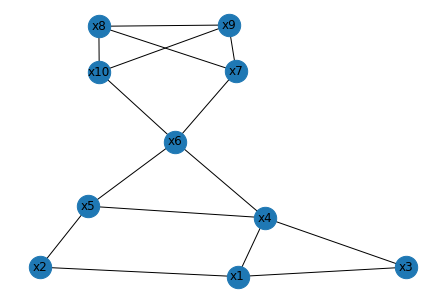

In [5]:
df = pd.read_csv("data_PHW2.csv")
data = np.array(df)
labels = df.columns
C = pc(data, indepTest, 0.02, labels)
show_graph_with_labels(C, labels)

<font color="orange" size=4>
    C) Implementing PC-stable algorithm
</font>

In [6]:
def pcStable(data, indepTest, alpha, labels):
    
    # data: observational data that we want to find its graph.
    # indepTest: a function of the form indepTest(x, y, S, data, alpha) which determines the independence of x,y given S.
    # alpha: confidence interval
    # labels: list of nodes' labels.
    
    def adj(C, i):
        # This function returns nodes adjacent to i
        # C: Graph matrix
        # i: i'th node
        return np.where(C[i, :] == 1)[0]
    
    def max_adj(C):
        # This function determines maximum number of nodes adjacent to some node in C
        # C: Graph matrix
        m = 0
        for i in range(len(labels)):
            if len(adj(C, i)) > m:
                m = len(adj(C, i))
        return m
    
    def lSubsets(iterable, l):
        # This function finds all subsets of an iterable with cardinality equal to l
        # iterale: the list or any other iterable object whose subsets we want to find
        # l: cardinality of subsets we're looking for
        s = list(iterable)
        return chain.from_iterable([combinations(s, l)])

    # C: a matix whose ij element indicates there is an edge between label(i) and label(j) if it's one, and vice versa.
    # Initializing C as a complete matrix
    C = np.ones((len(labels), len(labels))) - np.eye(len(labels))
    # l: level, the cardinality of condition set in each iteration.
    l = -1
    while l < max_adj(C):
        l += 1
        toBeDel = []
        for i in range(len(labels)):
            for j in range(len(labels)):
                if C[i, j] == 0:
                    continue
                else:
                    if len(adj(C, i)) - 1 < l:
                        break
                    else:
                        lCardSub = list(lSubsets(np.delete(adj(C, i), np.where(adj(C, i) == j)), l))
                        lCardSub = list(map(list, lCardSub))
                        for sub in lCardSub:
                            if indepTest(i, j, sub, data, alpha) == 1:
                                toBeDel += [[i, j]]
                                break
                                
        for i in toBeDel:
            C[i[0], i[1]] = C[i[1], i[0]] = 0
            
    return C

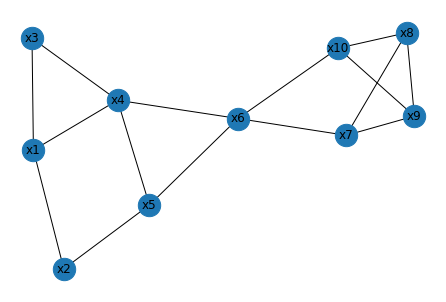

In [7]:
df = pd.read_csv("data_PHW2.csv")
data = np.array(df)
labels = df.columns
C = pcStable(data, indepTest, 0.02, labels)
show_graph_with_labels(C, labels)

<font color="orange" size=4>
    The graphs infered by PC and PC-stable are the same.
</font>

In [4]:
def randomDAG(n, prob, lB = 0.1, uB = 1):
    
    def weight(l):
        return np.random.uniform(lB, uB, l).round(2)
    
    V = np.arange(n)                        # All nodes
    Vleft = np.arange(n)                    # Nodes that have not been chosen
    CH = {i:np.array([]) for i in range(n)} # Dictionary that holds children of each node
    EW = {i:np.array([]) for i in range(n)} # Dictionary that holds weight of edges
    C = np.zeros((n, n))                    # Adjacancy matrix
    W = np.zeros((n, n))                    # Weight matrix
    
    for i in range(n):
        Vleft = np.delete(Vleft, np.where(Vleft == i))
        nonANi = np.array([j for j in V if j > i])
        edge = np.random.binomial(size=np.size(nonANi), n=1, p=prob)
        edgeWeights = weight(CH[i])
        CH[i] = nonANi[edge == 1]
        edgeWeights = weight(np.size(CH[i]))
        EW[i] = edgeWeights
    for i in range(n):
        C[i, CH[i].astype(int)] = 1
        W[i, CH[i].astype(int)] = EW[i]
    return C, W

In [2]:
def dagDrawer(C, W):
    n = C.shape[0]
    G = nx.DiGraph()
    G.add_nodes_from(np.arange(n))
    for i in range(C.shape[0]):
        G.add_edges_from([(i, j, {'weight': W[i, j]}) for j in range(C.shape[0]) if C[i, j] == 1])
    
    edge_labels=dict([((u,v,),d['weight'])
                 for u,v,d in G.edges(data=True)])
    pos=nx.spring_layout(G)
    plt.figure(figsize=(7, 7))
    # Uncomment the line below to show edge weights on them
    nx.draw_networkx_edge_labels(G,pos,edge_labels=edge_labels)
    nx.draw(G, pos, with_labels=True)

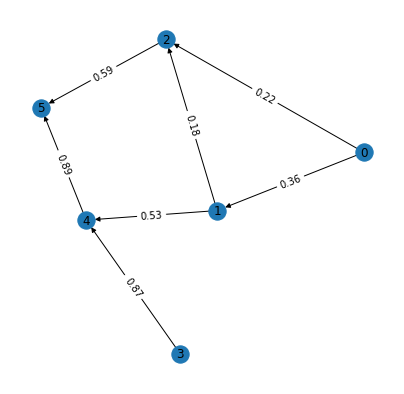

In [11]:
# Testing randomDAG
n = 6
AA, WW = randomDAG(n, 0.40)
dagDrawer(AA, WW)

In [10]:
def rmvDAG(n, dag, weight, exNoiseDist):
    nodeCount = dag.shape[0]
    exNoise = np.zeros((nodeCount, n))
    if exNoiseDist == 'normal':
        for i in range(nodeCount):
            exNoise[i, :] = np.random.normal(0, 1, n)
    else:
        print('Not defined')
        return None
    
    randomV = np.zeros((nodeCount, n))
    for i in range(nodeCount):
        randomV[i, :] = (weight[:, i] @ randomV) + exNoise[i, :]
    
    return randomV

In [11]:
nodeCount = 20
labels = np.arange(nodeCount)
trials = 200
confidenceLevel = np.array([0.0025, 0.005, 0.01, 0.02])
recall = np.zeros((np.size(confidenceLevel), trials))
missing = np.zeros((np.size(confidenceLevel), trials))
recallst = np.zeros((np.size(confidenceLevel), trials))
missingst = np.zeros((np.size(confidenceLevel), trials))

In [12]:
for i in range(np.size(confidenceLevel)):
    alpha = confidenceLevel[i]
    for k in tqdm(np.arange(trials)):
        A, W = randomDAG(nodeCount, 0.2, 0.1, 1)
        data = rmvDAG(1000, A, W, 'normal').T
        C = pc(data, indepTest, alpha, labels)
        Cstable = pcStable(data, indepTest, alpha, labels)
        recall[i, k] = np.sum(A * C) / np.sum(A)
        recallst[i, k] = np.sum(A * Cstable) / np.sum(A)
        missing[i, k] = np.sum((A - np.triu(C)) > 0) / np.sum(A)
        missingst[i, k] = np.sum((A - np.triu(Cstable))>0) / np.sum(A)

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [16:47<00:00,  4.26s/it]


In [13]:
print("Recall PC Algorithm: ", recall.mean(axis=1))

Recall PC Algorithm:  [0.7065411  0.70951284 0.71750731 0.72756483]


In [14]:
print("Recall PC Stable Algorithm: ", recallst.mean(axis=1))

Recall PC Stable Algorithm:  [0.70229006 0.70414841 0.71258936 0.72163015]


In [15]:
print("Missing PC Algorithm: ", missing.mean(axis=1))

Missing PC Algorithm:  [0.2934589  0.29048716 0.28249269 0.27243517]


In [16]:
print("Missing PC Stable: ", missingst.mean(axis=1))

Missing PC Stable:  [0.29770994 0.29585159 0.28741064 0.27836985]


<font color="orange" size=4>
    As we can see PC and PC Stable don't differ much. 
    <br />
    About the confidence level, as we increase it, the recall goes higher and number of missing edges decreases. That is because increasing alpha makes conditions for independence tighter. One thing to mention is that you can't set alpha a great number because it would decreas the precision(number of false positives). So it's better to compare F1 score to find the best alpha. 
</font>